# Analysis of VICTree output tree matrix

In [11]:
import h5py
import numpy as np
import networkx as nx
import seaborn as sns
from treesampling.algorithms import random_spanning_tree_log
from treesampling.utils.graphs import reset_adj_matrix, tree_to_newick

In [25]:
# load h5 file
vic_out = h5py.File("/Users/zemp/phd/scilife/victree-experiments/SA501X3F/victree-out/K12/victree.out.h5ad", 'r')
graph_matrix = vic_out['uns']['victree-tree-graph'][:]
# tempering:
graph_matrix = graph_matrix / 50
# graph_matrix = np.exp(graph_matrix)

In [26]:
import itertools
K = 12
ss = 500
graph = nx.complete_graph(K, create_using=nx.DiGraph)
for u, v in itertools.product(range(K), repeat=2):
    if v == 0 or u == v:
        graph_matrix[u, v] = -np.inf
graph = reset_adj_matrix(graph, graph_matrix)
nx.to_numpy_array(graph)

array([[           -inf, -4.44943391e+00, -6.21948526e+00,
        -4.54168001e+00, -5.20657067e+00, -3.78898597e+00,
        -4.87202323e+00, -4.97994083e+00, -4.47507298e+00,
        -5.29513991e+00, -1.87983379e+01, -4.85671524e+01],
       [           -inf,            -inf, -2.17902605e+00,
        -3.85785737e-01, -1.34914983e+00, -1.82420861e-01,
        -7.09158787e-01, -5.77419189e-01, -1.08939726e+00,
        -9.10501213e-01, -2.01381500e+01, -4.69782951e+01],
       [           -inf, -2.62150452e+00,            -inf,
        -2.86549491e+00, -3.65187316e+00, -2.56849214e+00,
        -3.54052873e+00, -3.41904533e+00, -3.08192613e+00,
        -3.34273598e+00, -2.37308283e+01, -4.87574587e+01],
       [           -inf, -3.84926114e-01, -2.60990143e+00,
                   -inf, -1.22141169e+00, -7.52385695e-03,
        -1.33962347e+00, -1.13182324e+00, -1.44855192e+00,
        -4.33083570e-01, -2.04358733e+01, -4.76846260e+01],
       [           -inf, -1.41899908e+00, -3.6027621

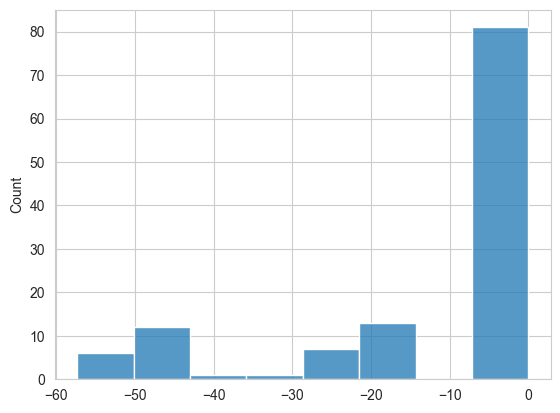

In [27]:
# histogram
g = sns.histplot(graph_matrix[~np.isinf(graph_matrix)])
# TODO: find why such skewed matrix don't run successfully in tree sampling

In [28]:
# draw 100 trees and save them in dict
sample = {}
for i in range(ss):
    tree = random_spanning_tree_log(graph, root=0)
    tnwk = tree_to_newick(tree)
    if tnwk not in sample:
        sample[tnwk] = 0
    sample[tnwk] += 1

sorted(sample.items(), key=lambda a: a[1], reverse=True)

/Users/zemp/PycharmProjects/treesampling/treesampling/utils/graphs.py:63: RuntimeWarning: invalid value encountered in subtract
  adj_mat = adj_mat - np.logaddexp.reduce(adj_mat, axis=axis, keepdims=True)
/Users/zemp/PycharmProjects/treesampling/treesampling/utils/math.py:13: RuntimeWarning: divide by zero encountered in log
  
/Users/zemp/PycharmProjects/treesampling/treesampling/utils/math.py:6: RuntimeWarning: invalid value encountered in scalar add
  if np.isclose(dx, 0):


AssertionError: l1: 0.014204401979897939, l2: nan